# Setup

In [1]:
pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [6]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-14 14:55:49.121318: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 14:55:51.216545: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-14 14:55:51.216609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30968 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [7]:
config = json.load(open("./configs/ext_mnn_em_bert_amazon_lr_1e-05.json"))

# Loading data

In [8]:
from data_loader.abo import ABO

In [9]:
data = ABO(path=config["data"]["path"],
           download=False,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=False,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'description2', 'path', 'product_type', 'label']]
# data = data.sample(10000)
data

Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,description2,path,product_type,label
0,shoesb0791vjhksamazon brand - symbol men's sne...,shoesb0791vjhksamazon brand - symbol men's sne...,4d/4d552519.jpg,SHOES,1
1,mobile coverb07tg4cyjvamazon brand - solimo de...,mobile coverb07tg4cyjvamazon brand - solimo de...,4d/4de76f7f.jpg,CELLULAR_PHONE_CASE,1
2,"mobile coverb0856b8fw1sunshine swatch, ravenna...",combo cooker dutch oven for bread making ovens...,72/72c5b6c9.jpg,GROCERY,0
3,"whole foods, whole food, whole foods,365 every...",cellphonecoverb07tf7gr3ywhole foods market cre...,85/854b1468.jpg,CELLULAR_PHONE_CASE,0
4,back coverb00no73q84amazon brand - solimo desi...,mobile coverb071gvmr85amazon brand - solimo de...,6a/6a127d3e.jpg,BOOT,0
...,...,...,...,...,...
168221,mobile coverb07y33f9kxamazon brand - solimo de...,handbags for women latest brandedb072kwqy8yama...,e6/e6ed7731.jpg,CELLULAR_PHONE_CASE,0
168222,amazonbasics;amzn-lt800p-a;replacement-refrige...,amazonbasics;amzn-lt800p-a;replacement-refrige...,73/73903c65.jpg,MAJOR_HOME_APPLIANCES,1
168223,placeholderb074h67h9qamazon brand - solimo des...,deb0854kjcylamazon brand - solimo designer cou...,10/10b2c3af.jpg,CELLULAR_PHONE_CASE,0
168224,mobile coverb0854ljhw2half tofu banh mi,mobile coverb081hmxdkvfind. women's velvet str...,de/de19c121.jpg,GROCERY,0


In [10]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
text2 = data["description2"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing (only explorative purposes)

The following part is largely based off of https://www.tensorflow.org/text/guide/bert_preprocessing_guide

## generate text embeddings directly with BERT

In [11]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [14]:
# text

In [15]:
# text = bert_model(text)

# print(f'Loaded BERT: {tfhub_handle_encoder}')
# print(f'Pooled Outputs Shape:{text["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{text["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{text["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{text["sequence_output"][0, :12]}')

In [16]:
# text = text["pooled_output"]
# text.shape

# Image processing

In [17]:
from utils.img_processing import load_img_model, create_embeddings_from

In [18]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [19]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "images/small"),
                             batch_size=4096)

Found 168226 validated image filenames.


2023-06-14 14:58:06.615033: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8700
2023-06-14 14:58:17.065797: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


In [20]:
img.shape

(168226, 576)

# Save embeddings

In [21]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/bert/{img_model.name}")

In [22]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
np.save(f"{save_path}/text2.npy", text2)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [23]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,description2,path,product_type,label
0,shoesb0791vjhksamazon brand - symbol men's sne...,shoesb0791vjhksamazon brand - symbol men's sne...,4d/4d552519.jpg,SHOES,1
1,mobile coverb07tg4cyjvamazon brand - solimo de...,mobile coverb07tg4cyjvamazon brand - solimo de...,4d/4de76f7f.jpg,CELLULAR_PHONE_CASE,1
2,"mobile coverb0856b8fw1sunshine swatch, ravenna...",combo cooker dutch oven for bread making ovens...,72/72c5b6c9.jpg,GROCERY,0
3,"whole foods, whole food, whole foods,365 every...",cellphonecoverb07tf7gr3ywhole foods market cre...,85/854b1468.jpg,CELLULAR_PHONE_CASE,0
4,back coverb00no73q84amazon brand - solimo desi...,mobile coverb071gvmr85amazon brand - solimo de...,6a/6a127d3e.jpg,BOOT,0
...,...,...,...,...,...
168221,mobile coverb07y33f9kxamazon brand - solimo de...,handbags for women latest brandedb072kwqy8yama...,e6/e6ed7731.jpg,CELLULAR_PHONE_CASE,0
168222,amazonbasics;amzn-lt800p-a;replacement-refrige...,amazonbasics;amzn-lt800p-a;replacement-refrige...,73/73903c65.jpg,MAJOR_HOME_APPLIANCES,1
168223,placeholderb074h67h9qamazon brand - solimo des...,deb0854kjcylamazon brand - solimo designer cou...,10/10b2c3af.jpg,CELLULAR_PHONE_CASE,0
168224,mobile coverb0854ljhw2half tofu banh mi,mobile coverb081hmxdkvfind. women's velvet str...,de/de19c121.jpg,GROCERY,0


In [24]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(168226, 576)

In [25]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(168226,)

In [26]:
text2 = np.load(f"{save_path}/text2.npy", allow_pickle=True)
text2.shape

(168226,)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [27]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [28]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
train, test, labels_train, labels_test = train_test_split(
    data,
    labels,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [31]:
img_train = img[train.index]
img_test = img[test.index]

text_train = train["description"]
text_test = test["description"]

text2_train = train["description2"]
text2_test = test["description2"]

# Build BERT model (only explorative purposes)

In [32]:
text_input = tf.keras.layers.Input(shape=(()), dtype=tf.string)

x = bert_preprocess_model(text_input)

text_output = bert_model(x)["pooled_output"]

some_model = tf.keras.models.Model(text_input, text_output)

some_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input_2[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [33]:
some_model(test[:5]["description"])

<tf.Tensor: shape=(5, 768), dtype=float32, numpy=
array([[-0.8342786 , -0.49116412, -0.9826002 , ..., -0.9584874 ,
        -0.59756213,  0.58473396],
       [-0.8792041 , -0.47566673, -0.98103994, ..., -0.9467691 ,
        -0.5948945 ,  0.7237315 ],
       [-0.8658173 , -0.5659161 , -0.99107826, ..., -0.9591521 ,
        -0.62935627,  0.65495986],
       [-0.85190654, -0.45063606, -0.9672013 , ..., -0.91835827,
        -0.5731304 ,  0.6700334 ],
       [-0.72803193, -0.460802  , -0.9536089 , ..., -0.89755416,
        -0.66318834,  0.47983623]], dtype=float32)>

# Save Char CNN config

Not needed, as we use BERT for text embeddings instead

In [34]:
# from models.char_cnn_zhang import CharCNNZhang

In [35]:
# char_cnn_config = {
#     "input_size": config["data"]["input_size"],
#     "embedding_size": len(tk.word_index),
#     "conv_layers": config["char_cnn_zhang"]["conv_layers"],
#     "fc_layers": config["char_cnn_zhang"]["fc_layers"],
#     "output_size": config["char_cnn_zhang"]["output_size"],
#     "embedding_weights": weights
# }

In [36]:
# char_cnn = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

![](../../assets/images/MNN_EM.png)

In [43]:
# from models.mnn_em import MNNEM
from utils.metrics import create_metrics

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Multiply, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, CosineSimilarity


class MNNEMBert(object):
    def __init__(
            self, head_config, combined_fc_layers, learning_rate,
            metrics=["recall", "precision", "binary_accuracy", "cosine_similarity"],
            loss='binary_crossentropy', name="MNN_EM") -> None:
        self.head_config = head_config
        self.combined_fc_layers = combined_fc_layers
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.loss = loss
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        img_features = Input(
            shape=(self.head_config["img_input_size"]), name="Image_Input")

        # Input Layer
        text_features = Input(
            shape=(()), dtype=tf.string, name="Text_Input")

        x = _MNNEMHead(**self.head_config)

        x = x.model([img_features, text_features])

        # FC Layers
        for i, comb_fl in enumerate(self.combined_fc_layers, 1):
            x = Dense(comb_fl, activation='relu',
                      name=f"Combined_FC_{i}")(x)

        output = Dense(1, activation='sigmoid', name="Sigmoid")(x)
        model = Model(inputs=[img_features, text_features],
                      outputs=output, name=self.name)

        optimizer = Adam(learning_rate=self.learning_rate)

        model.compile(optimizer=optimizer, loss=self.loss,
                      metrics=self.metrics)
        self.model = model
        # print("MNN-EM model built: ")
        # self.model.summary()


class _MNNEMHead(object):
    def __init__(self, img_input_size, txt_input_size, img_fc_layers,
                 txt_fc_layers, extended):
        self.img_input_size = img_input_size
        self.txt_input_size = txt_input_size
        self.img_fc_layers = img_fc_layers
        self.txt_fc_layers = txt_fc_layers
        self.extended = extended
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Text Input
        img_features = Input(shape=(self.img_input_size),
                             name="Image_Input_Head_Outer")

        img_cnn = _CNNBranch(self.img_input_size,
                             self.img_fc_layers, self.extended, name="Image")

        output_img = img_cnn.model(img_features)

        # Image Input
        text_features = tf.keras.layers.Input(shape=(()), dtype=tf.string, name="Text_Input_Head_Outer")

        bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
        bert_model = hub.KerasLayer(tfhub_handle_encoder)

        x = bert_preprocess_model(text_features)

        x = bert_model(x)["pooled_output"]

        text_cnn = _CNNBranch(x.shape[1],
                             self.txt_fc_layers, self.extended, name="Text")

        output_text = text_cnn.model(x)

        # Element-wise product
        combined = Multiply(
            name="Element-wise_Multiplication")([output_img, output_text])

        model = Model(inputs=[img_features, text_features],
                      outputs=combined, name="MNN_EM_Head")

        self.model = model


class _CNNBranch(object):
    def __init__(self, input_size, fc_layers, extended, name):
        self.input_size = input_size
        self.fc_layers = fc_layers
        self.extended = extended
        self.name = name
        self._build_model()  # builds self.model variable

    def _build_model(self):
        # Input Layer
        features = Input(shape=(self.input_size),
                         name=f"{self.name}_Input_Head_Inner")

        # fc + ReLU
        for i, fl in enumerate(
                self.fc_layers[: None if self.extended else -1],
                1):
            x = Dense(fl, activation='relu',
                      name=f"{self.name}_FC_{i}")(features if i == 1 else x)

        if not self.extended:
            # fc + L2 Norm
            x = Dense(
                self.fc_layers[-1],
                kernel_regularizer='l2', name=f"{self.name}_FC_last")(
                features if len(self.fc_layers) == 1 else x)

        output = BatchNormalization(name=f"{self.name}_Batch_Normalization")(x)

        model = Model(inputs=features, outputs=output, name=f"{self.name}_CNN")

        self.model = model

class ExtendedMNNEMBert(object):
    def __init__(self, head_1_config, head_2_config,
                 combined_fc_layers, learning_rate,
                 metrics=["recall", "precision", "binary_accuracy",
                          "cosine_similarity"],
                 loss='binary_crossentropy') -> None:
        self.head_1_config = head_1_config
        self.head_2_config = head_2_config
        self.combined_fc_layers = combined_fc_layers
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.loss = loss
        self._build_model()  # builds self.model variable

    def _build_model(self):
        head = _MNNEMHead(**self.head_1_config)

        tail = MNNEMBert(
            head_config=self.head_2_config,
            combined_fc_layers=self.combined_fc_layers,
            learning_rate=self.learning_rate,
            metrics=self.metrics,
            name="MNN_EM_Tail")

        # Input Layer
        img_features = Input(
            shape=(self.head_1_config["img_input_size"]), name="Image_Input")

        # Input Layer
        text_features = tf.keras.layers.Input(shape=(()), dtype=tf.string, name="Text_Input")

        # Input Layer
        text_2_features = tf.keras.layers.Input(shape=(()), dtype=tf.string, name="Text_2_Input")

        x = head.model([img_features, text_features])

        x = tail.model([x, text_2_features])

        model = Model(inputs=[img_features, text_features,
                      text_2_features], outputs=x, name="Extended_MNN_EM")

        optimizer = Adam(learning_rate=self.learning_rate)

        model.compile(optimizer=optimizer, loss=self.loss,
                      metrics=self.metrics)

        self.model = model

In [45]:
head_1_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["img_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_1_fc_layers"],
    "extended": True,
}

In [46]:
head_2_config = {
    "img_input_size": config["model"]["img_1_fc_layers"][-1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["combined_1_fc_layers"],
    "txt_fc_layers": config["model"]["txt_2_fc_layers"],
    "extended": False,
}

In [47]:
ext_mnn_em = ExtendedMNNEMBert(
    head_1_config=head_1_config,
    head_2_config=head_2_config,
    combined_fc_layers=config["model"]["combined_2_fc_layers"],
    learning_rate=config["model"]["training"]["learning_rate"],
    metrics=create_metrics(config["model"]["training"]["metrics"]))

In [48]:
ext_mnn_em.model.summary(expand_nested=True)

Model: "Extended_MNN_EM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 1024)         110868737   ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Text_Input_Head_Outer (InputLa  [(None,)]         0           []                  

In [49]:
# Full model

tf.keras.utils.plot_model(ext_mnn_em.model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Callbacks

In [50]:
from utils.metrics import create_callbacks

In [51]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [52]:
# Model is too big to save

config["model"]["training"]["callbacks"] = ['early_stopping', 'tensorboard']

In [53]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

# Training

In [54]:
history = ext_mnn_em.model.fit(
    x=[img_train, text_train, text2_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10
8515/8515 [==============================] - 1045s 121ms/step - loss: 7.1448 - recall: 0.6908 - precision: 0.7287 - binary_accuracy: 0.7055 - cosine_similarity: 0.5200 - val_loss: 3.7979 - val_recall: 0.8127 - val_precision: 0.8763 - val_binary_accuracy: 0.8445 - val_cosine_similarity: 0.5147
Epoch 2/10
8515/8515 [==============================] - 1031s 121ms/step - loss: 2.8387 - recall: 0.9099 - precision: 0.9035 - binary_accuracy: 0.9026 - cosine_similarity: 0.5200 - val_loss: 2.1959 - val_recall: 0.8917 - val_precision: 0.9449 - val_binary_accuracy: 0.9175 - val_cosine_similarity: 0.5147
Epoch 3/10
8515/8515 [==============================] - 1033s 121ms/step - loss: 1.7534 - recall: 0.9578 - precision: 0.9452 - binary_accuracy: 0.9492 - cosine_similarity: 0.5200 - val_loss: 1.5386 - val_recall: 0.9224 - val_precision: 0.9298 - val_binary_accuracy: 0.9242 - val_cosine_similarity: 0.5144
Epoch 4/10
8515/8515 [==============================] - 1034s 121ms/step - loss: 1.20

# Evaluation

## Plot loss and metrics

In [55]:
from utils.metrics import plot_metrics

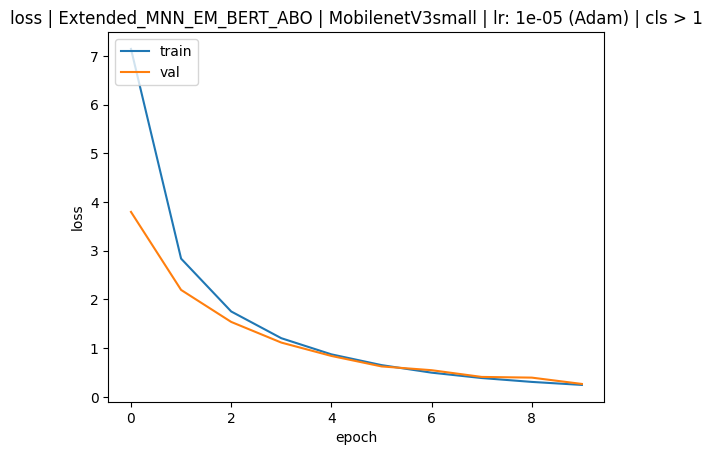

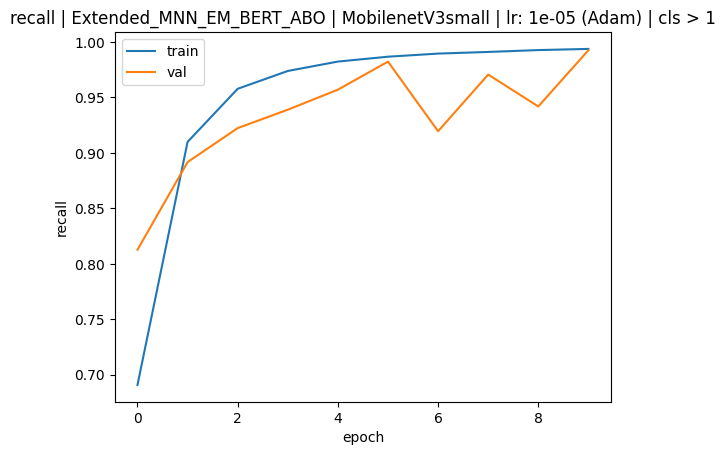

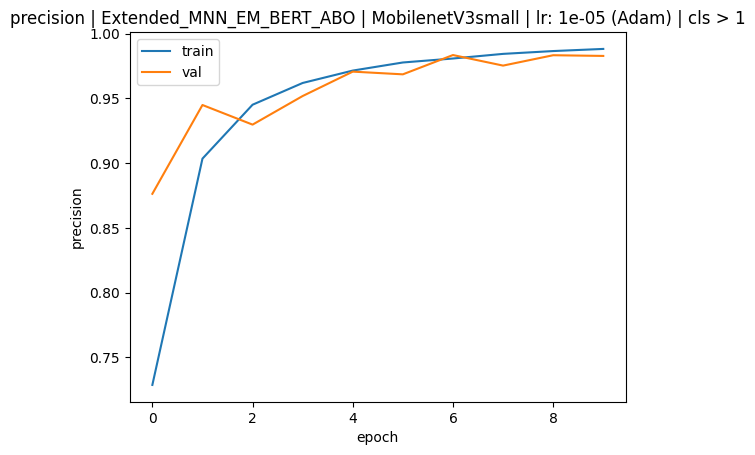

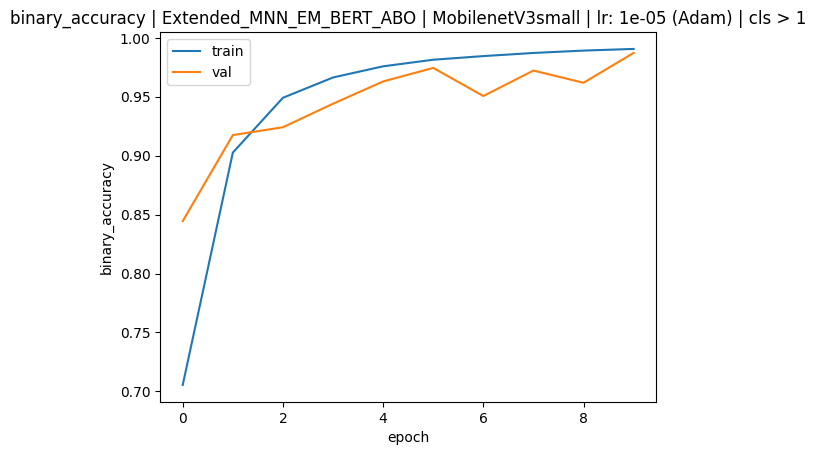

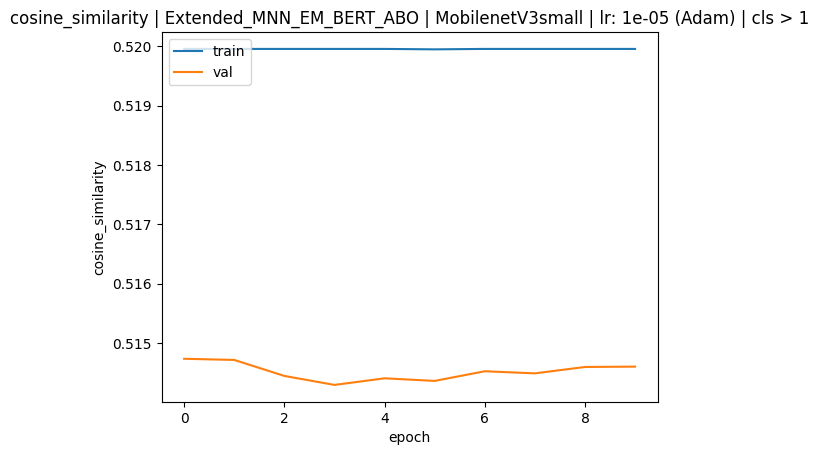

In [56]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [57]:
from utils.metrics import evaluate

In [58]:
evaluate(ext_mnn_em.model, [img_test, text_test, text2_test], labels_test, log_dir, model_name,
         img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

16820/16820 [==============================] - 283s 17ms/step - loss: 0.2714 - recall: 0.9934 - precision: 0.9801 - binary_accuracy: 0.9861 - cosine_similarity: 0.5185
